# This notebook demonstrates self-distillation of a Denoising Diffusion transformer model

# Imports

In [2]:
# !pip install diffusers timm --upgrade
# !pip install filelock

In [1]:
from util_DiT import *
import os
%reload_ext autoreload
%autoreload 2
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
# torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

cwd = os.getcwd()

c:\Users\Administrator\anaconda3\envs\DSD\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Creating Model

In [2]:
# Setting up image sizes
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8

# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

# Doing a single denoising step

In [4]:
n = 1
num_sampling_steps = 4 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = [207]
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))
# Sample inputs:
z = torch.randn(1, model.in_channels, latent_size, latent_size, device=device)
y = torch.randint(0, 1, (n,), device=device)

# Setup classifier-free guidance:

z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=4)
sample_fn = model.forward_with_cfg


# Sample images:
samples = diffusion.ddim_sample_loop_progressive(
    sample_fn, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=False, device=device
)

samples, _ = samples.chunk(2, dim=0)  # Remove null class samples

samples = vae.decode(samples / 0.18215).sample
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:27                                                                                   │
│                                                                                                  │
│   24 │   sample_fn, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=Fals    │
│   25 )                                                                                           │
│   26                                                                                             │
│ ❱ 27 samples, _ = samples.chunk(2, dim=0)  # Remove null class samples                           │
│   28                                                                                             │
│   29 samples = vae.decode(samples / 0.18215).sample                                              │
│   30 save_image(samples, "sample.png", nrow=int(samples_per_row),                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'generator' object has no attribute 'chunk'

In [5]:
samples, pred_xstart = sample_step_grad(model.forward_with_cfg_grad, diffusion, 4, model_kwargs, timesteps, samples)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 samples, pred_xstart = sample_step_grad(model.forward_with_cfg_grad, diffusion, step, mo     │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'sample_step_grad' is not defined

# Distillation Loop

In [1]:
import util_DiT
import os
%reload_ext autoreload
%autoreload 2
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(True)
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

cwd = os.getcwd()
# Setting up image sizes
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8

# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to("cuda")
del state_dict, vae_model
torch.cuda.empty_cache()
steps = 20
generations = 10
decrease_steps = False

# !set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128'

c:\Users\Administrator\anaconda3\envs\DSD\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[3, 2, 1, 0]


100%|██████████| 4/4 [00:00<00:00,  9.87it/s]


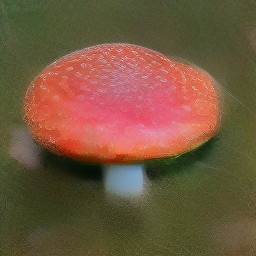

In [23]:
# # Set user inputs:
# seed = 0 #@param {type:"number"}
# torch.manual_seed(seed)
num_sampling_steps = 4 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = [992] #@param {type:"raw"}
samples_per_row = 1 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = 1
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.ddim_sample_loop_progressive(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

# With intermediate steps!

  0%|          | 0/4 [00:00<?, ?it/s]

3


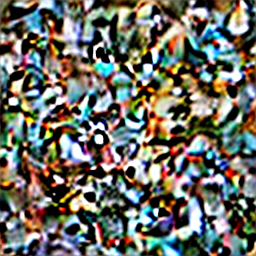

 25%|██▌       | 1/4 [00:00<00:00,  4.25it/s]

2


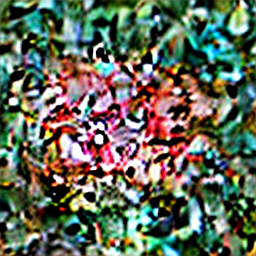

 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

1


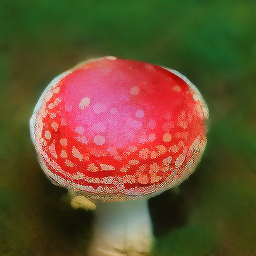

 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

0


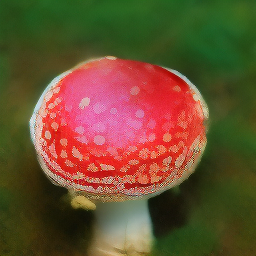

100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


In [16]:
# # Set user inputs:
# seed = 0 #@param {type:"number"}
# torch.manual_seed(seed)
import tqdm
num_sampling_steps =4 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = [992] #@param {type:"raw"}
samples_per_row = 1 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = 1
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)


samples = torch.randn(z.shape, device=device)
indices = list(range(diffusion.num_timesteps))[::-1]
for i in tqdm.tqdm(indices):
    print(i)
    samples = diffusion.ddim_sample_loop_progressive_intermediate(
            model.forward_with_cfg, z.shape, noise=samples, clip_denoised=False, 
            model_kwargs=model_kwargs, progress=False, device=device, step=i)
    img, _ = samples.chunk(2, dim=0)  # Remove null class samples
    img = vae.decode(img / 0.18215).sample
    if i == 1:
        last = img
    else:
        final = img
    # Save and display images:
    save_image(img, "sample.png", nrow=int(samples_per_row), 
            normalize=True, value_range=(-1, 1))
    img = Image.open("sample.png")
    display(img)

# img, _ = samples.chunk(2, dim=0)  # Remove null class samples
# img = vae.decode(img / 0.18215).sample

# # Save and display images:
# save_image(img, "sample.png", nrow=int(samples_per_row), 
#         normalize=True, value_range=(-1, 1))
# img = Image.open("sample.png")
# display(img)
# samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
# samples = vae.decode(samples / 0.18215).sample

# # Save and display images:
# save_image(samples, "sample.png", nrow=int(samples_per_row), 
#            normalize=True, value_range=(-1, 1))
# samples = Image.open("sample.png")
# display(samples)